# TA05 – Visão Computacional e Percepção

## Multilayer Perceptron From Scratch

### Integrantes
- **Luan de Oliveira Magalhães**  
- **Raul José Silvério da Silva**  
- **Vinícius Lázaro Bartolomeu**  

---

> Notebook original adaptado de **Vítor Gama Lemos**  
> [Multilayer Perceptron From Scratch (Kaggle)](https://www.kaggle.com/code/vitorgamalemos/multilayer-perceptron-from-scratch)

In [511]:
import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm



seaborn.set(style='whitegrid'); seaborn.set_context('talk')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.datasets import load_iris
iris_data = load_iris()

In [512]:
print(iris_data['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Number of samples: 150
Number of features: 4 



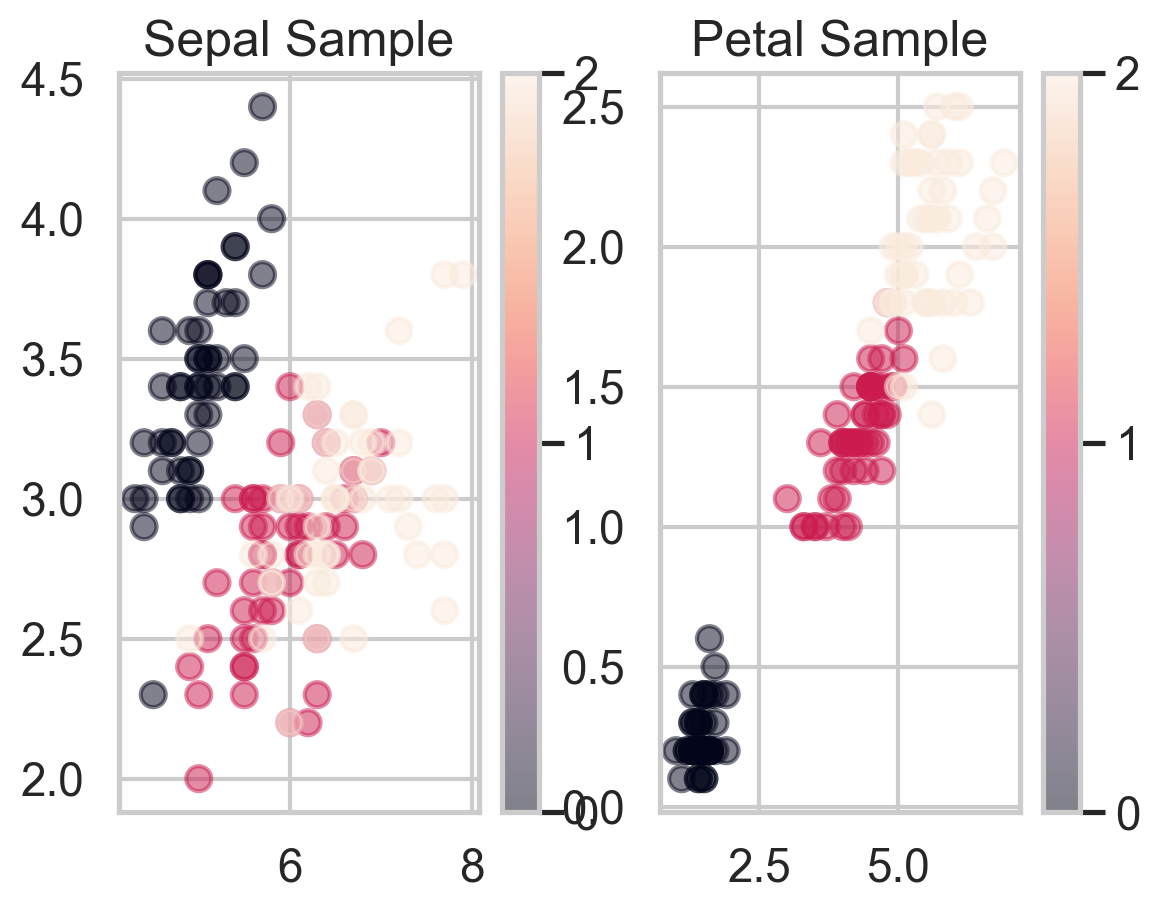

In [513]:
n_samples, n_features = iris_data.data.shape

print(f"Number of samples: {n_samples}")
print(f"Number of features: {n_features} \n")

plt.subplot(1, 2, 1)
scatter_plot = plt.scatter(iris_data.data[:,0], iris_data.data[:,1], alpha=0.5,
                           c=iris_data.target)
plt.colorbar(ticks=([0, 1, 2]))
plt.title('Sepal Sample');

plt.subplot(1, 2, 2)
scatter_plot_2 = plt.scatter(iris_data.data[:,2], iris_data.data[:,3], alpha=0.5,
                           c=iris_data.target)
plt.colorbar(ticks=([0, 1, 2]))
plt.title('Petal Sample');

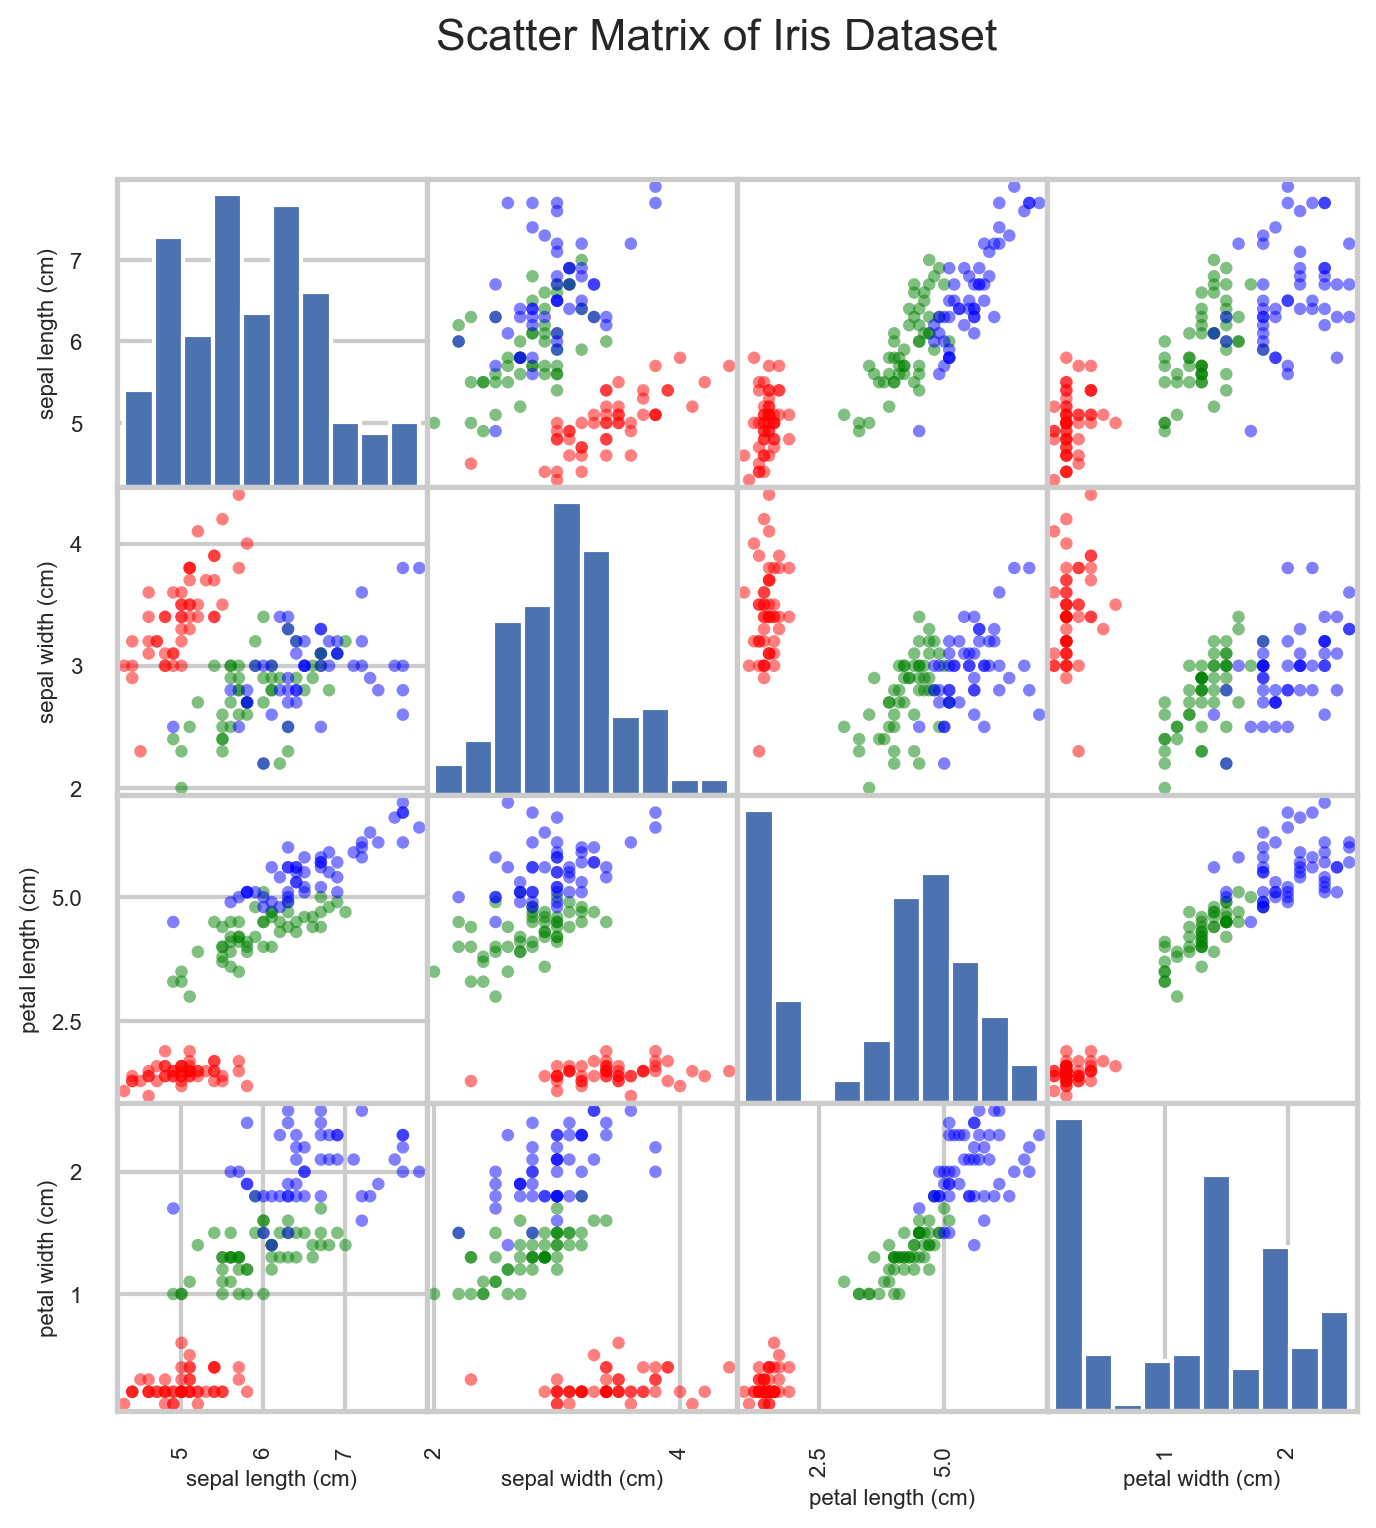

In [514]:
import pandas
from pandas.plotting import scatter_matrix


# Cria um DataFrame com os dados e os nomes das colunas
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df['target'] = iris_data.target

# Mapeia os números das classes para nomes legíveis
target_names = iris_data.target_names
df['target_name'] = df['target'].apply(lambda i: target_names[i])

# Escolhe uma paleta de cores
colors = {'setosa': 'red', 'versicolor': 'green', 'virginica': 'blue'}
df['color'] = df['target_name'].map(colors)

# Gera o scatter_matrix
axes = scatter_matrix(df[iris_data.feature_names],
               figsize=(8, 8),
               diagonal='hist',
               color=df['color'],
               alpha=0.5)

# Reduz o tamanho da fonte dos rótulos dos eixos
for ax in axes.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)

plt.suptitle("Scatter Matrix of Iris Dataset", fontsize=16)
plt.show()

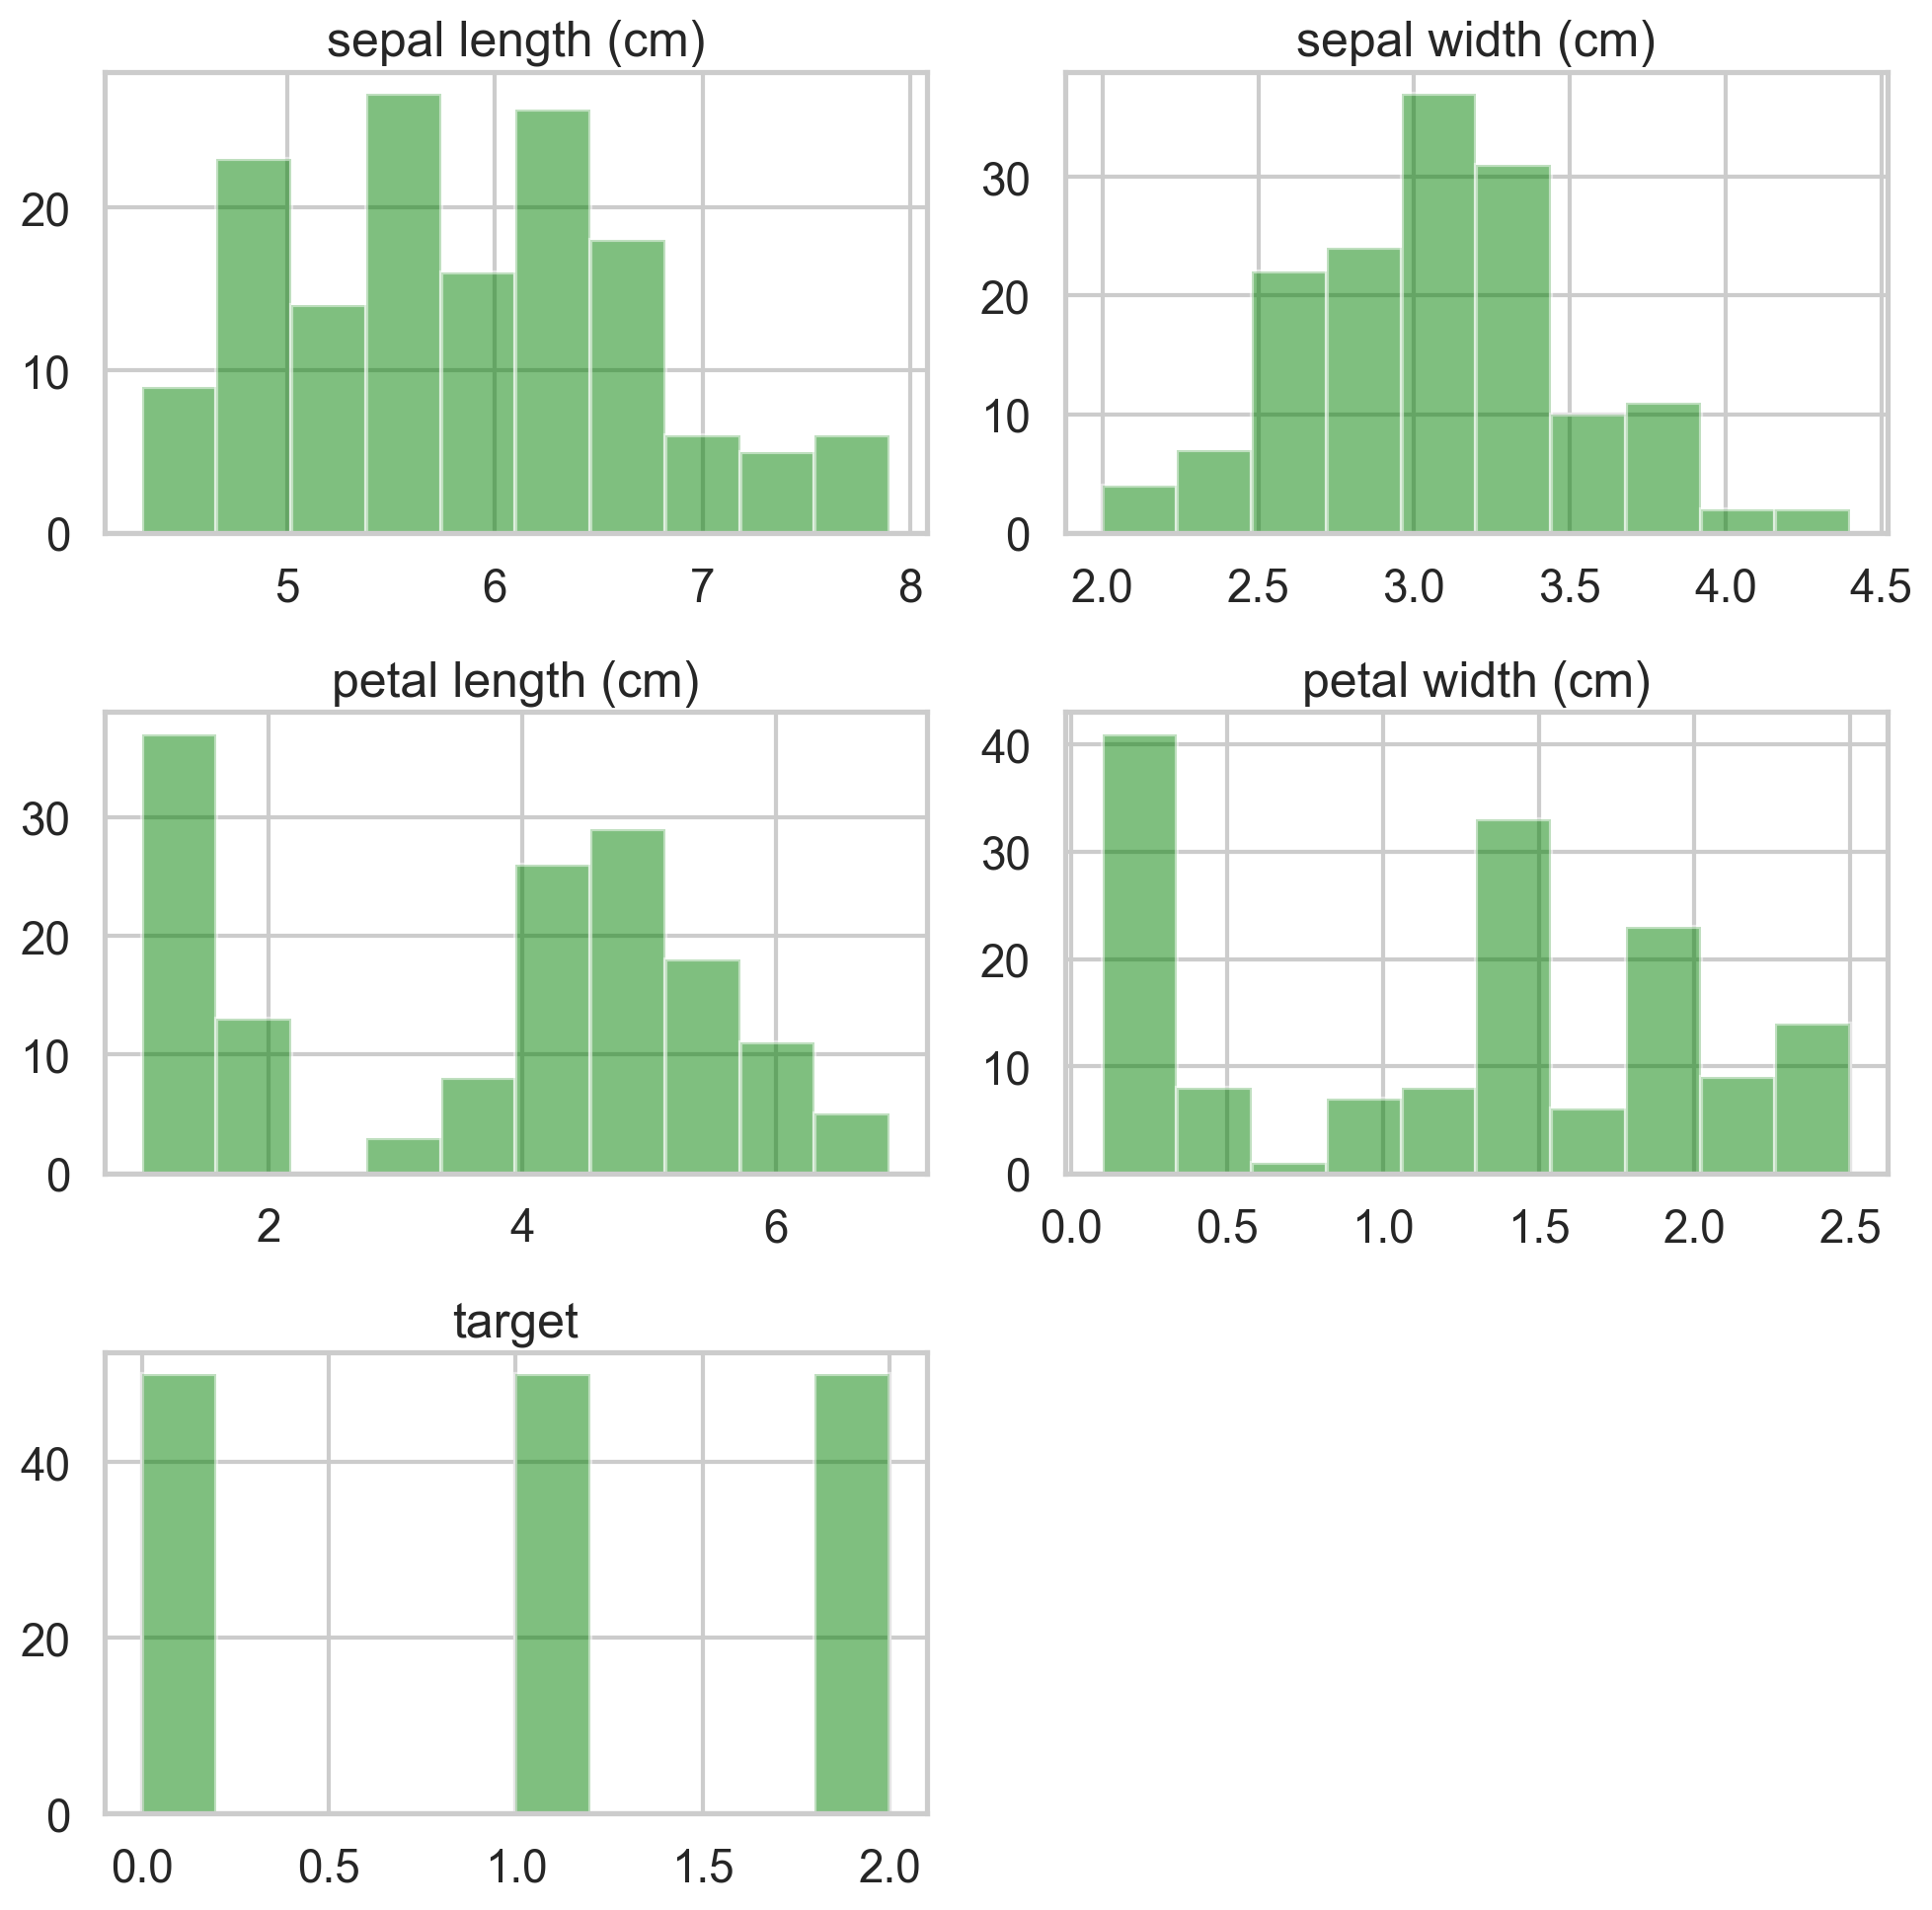

In [515]:
axes = df.hist(alpha=0.5, figsize=(10, 10), color='green')

plt.tight_layout()
plt.show()

> #### ✅ Shuffle CORRIGIDO
>
> Agora mantemos `iris_dataset` como NumPy e usamos  
> `train_test_split` com `stratify=y` para garantir  
> 20% de cada classe no teste.


In [516]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

random.seed(123)
np.random.seed(123)

# Load the Iris dataset
iris_data = load_iris()

X, y = iris_data.data, iris_data.target

# Use train_test_split to divide into 80% train, 20% test
train_X, test_X, train_y, test_y = train_test_split(
    X, y,
    test_size=0.2,
    random_state=11,  # set for reproducibility
    stratify=y        # keep label proportions balanced
)

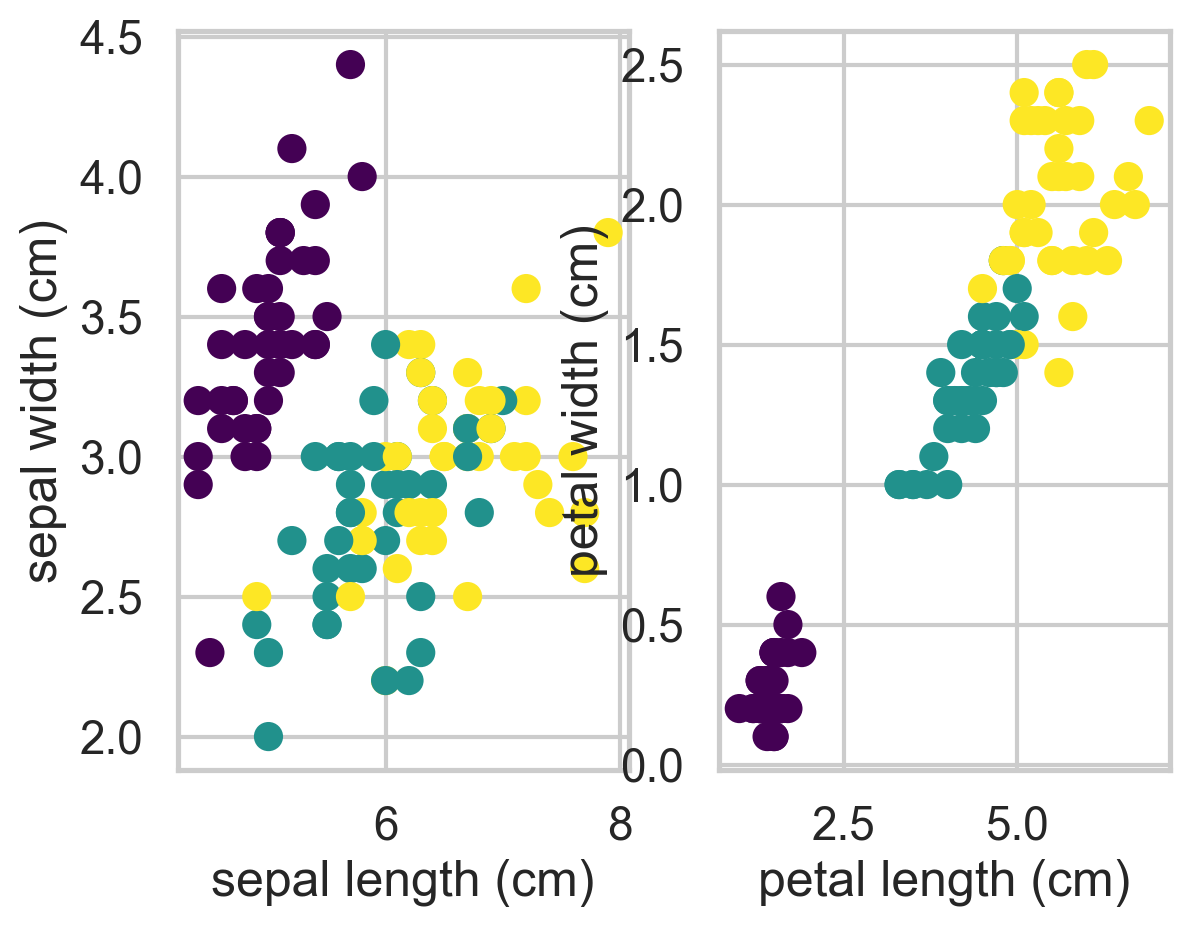

In [517]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Plot training Samples

plt.subplot(1, 2, 1)
plt.scatter(train_X[:,0],train_X[:,1],c=train_y,cmap=cm.viridis)
plt.xlabel(iris_data.feature_names[0])
plt.ylabel(iris_data.feature_names[1])

plt.subplot(1, 2, 2)
plt.scatter(train_X[:,2],train_X[:,3],c=train_y,cmap=cm.viridis)
plt.xlabel(iris_data.feature_names[2])
plt.ylabel(iris_data.feature_names[3]);

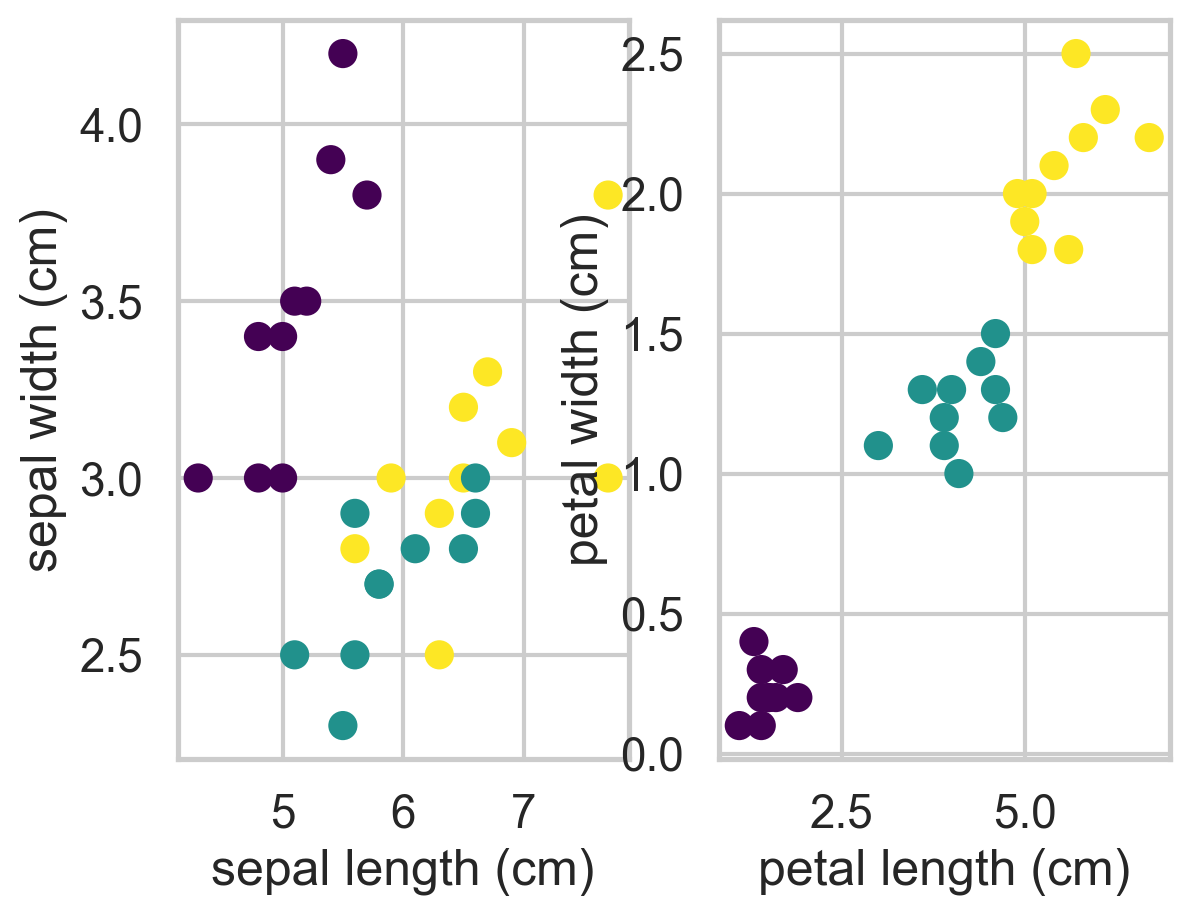

In [518]:
# Plot test samples
plt.subplot(1, 2, 1)
plt.scatter(test_X[:,0],test_X[:,1],c=test_y,cmap=cm.viridis)
plt.xlabel(iris_data.feature_names[0])
plt.ylabel(iris_data.feature_names[1])

plt.subplot(1, 2, 2)
plt.scatter(test_X[:,2],test_X[:,3],c=test_y,cmap=cm.viridis)
plt.xlabel(iris_data.feature_names[2])
plt.ylabel(iris_data.feature_names[3]);

In [519]:
# Implementation the Multilayer Perceptron in Python
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
import random
import numpy as np
import matplotlib.pyplot as plt

class MultiLayerPerceptron(BaseEstimator, ClassifierMixin):

    def __init__(self, params=None):
        # Store the params argument to satisfy BaseEstimator requirements
        self.params = params

        if (params == None):
            self.inputLayer = 4                        # Input Layer
            self.hiddenLayer = 5                       # Hidden Layer
            self.outputLayer = 3                       # Outpuy Layer
            self.learningRate = 0.005                  # Learning rate
            self.max_epochs = 600                      # Epochs
            self.BiasHiddenValue = -1                   # Bias HiddenLayer
            self.BiasOutputValue = -1                  # Bias OutputLayer
            self.activation = self.ativacao['sigmoid'] # Activation function
            self.deriv = self.derivada['sigmoid']
        else:
            self.inputLayer = params['InputLayer']
            self.hiddenLayer = params['HiddenLayer']
            self.outputLayer = params['OutputLayer']
            self.learningRate = params['LearningRate']
            self.max_epochs = params['Epocas']
            self.BiasHiddenValue = params['BiasHiddenValue']
            self.BiasOutputValue = params['BiasOutputValue']
            self.activation = self.ativacao[params['ActivationFunction']]
            self.deriv = self.derivada[params['ActivationFunction']]

        # Starting Bias and Weights
        # assign ramdom values [-1 .. +1] in order to start with some weights
        # not so symmetric
        # Weight initialization: passing correct arguments to starting_weights
        self.WEIGHT_hidden = self.starting_weights(self.inputLayer, self.hiddenLayer)
        self.WEIGHT_output = self.starting_weights(self.hiddenLayer, self.outputLayer)

        self.BIAS_hidden = np.array([self.BiasHiddenValue for i in range(self.hiddenLayer)])
        self.BIAS_output = np.array([self.BiasOutputValue for i in range(self.outputLayer)]) # Corrected attribute name
        self.classes_number = 3

    pass

    # This function creates a 2D matrix of random values between -1 and +1
    # Shape: rows x columns
    def starting_weights(self, rows, columns):
        return [[2  * random.random() - 1 for _ in range(columns)] for _ in range(rows)]

    ativacao = {
         'sigmoid': (lambda x: 1/(1 + np.exp(-x))),
            'tanh': (lambda x: np.tanh(x)),
            'Relu': (lambda x: x*(x > 0)),
               }
    derivada = {
         'sigmoid': (lambda x: x*(1-x)),
            'tanh': (lambda x: 1-x**2),
            'Relu': (lambda x: 1 * (x>0))
               }

    # This calculates the error at the output layer and then propagates it
    # backward through the network to update the weights in each layer
    def Backpropagation_Algorithm(self, x):
        DELTA_output = []
        # Stage 1 - Error: OutputLayer (target - predicted)
        ERROR_output = self.output - self.OUTPUT_L2
        DELTA_output = ((-1)*(ERROR_output) * self.deriv(self.OUTPUT_L2))

        arrayStore = []
        # Stage 2 - Update weights OutputLayer and HiddenLayer
        for i in range(self.hiddenLayer):
            for j in range(self.outputLayer): # Corrected attribute name
                self.WEIGHT_output[i][j] -= (self.learningRate * (DELTA_output[j] * self.OUTPUT_L1[i]))
                self.BIAS_output[j] -= (self.learningRate * DELTA_output[j])

        # Stage 3 - Error: HiddenLayer
        delta_hidden = np.matmul(self.WEIGHT_output, DELTA_output)* self.deriv(self.OUTPUT_L1)

        # Stage 4 - Update weights HiddenLayer and InputLayer(x)
        for i in range(self.inputLayer):
            for j in range(self.hiddenLayer):
                self.WEIGHT_hidden[i][j] -= (self.learningRate * (delta_hidden[j] * x[i]))
                self.BIAS_hidden[j] -= (self.learningRate * delta_hidden[j])



    def show_err_graphic(self,v_erro,v_epoca):
        plt.figure(figsize=(9,4))
        plt.plot(v_epoca, v_erro, color="b", marker=11)
        plt.xlabel("Number of Epochs")
        plt.ylabel("Squared error (MSE) ");
        plt.title("Error Minimization")
        plt.show()


    def predict(self, X, y):
        'Returns the predictions for every element of X'
        my_predictions = []
        'Forward Propagation'
        forward = np.matmul(X,self.WEIGHT_hidden) + self.BIAS_hidden
        forward = np.matmul(forward, self.WEIGHT_output) + self.BIAS_output
        for i in forward:
            my_predictions.append(max(enumerate(i), key=lambda x:x[1])[0])

        array_score = []
        for i in range(len(my_predictions)):
            if my_predictions[i] == 0:
                array_score.append([i, 'Iris-setosa', my_predictions[i], y[i]])
            elif my_predictions[i] == 1:
                 array_score.append([i, 'Iris-versicolour', my_predictions[i], y[i]])
            elif my_predictions[i] == 2:
                 array_score.append([i, 'Iris-virginica', my_predictions[i], y[i]])

        dataframe = pd.DataFrame(array_score, columns=['_id', 'class', 'output', 'hoped_output'])
        return my_predictions, dataframe

    def fit(self, X, y):
        count_epoch = 1
        total_error = 0
        n = len(X);
        epoch_array = []
        error_array = []
        # Initialize lists to store specific weight values for plotting
        weight_over_epochs_W0_plot = []
        weight_over_epochs_W1_plot = []


        while(count_epoch <= self.max_epochs):
            for idx,inputs in enumerate(X):
                self.output = np.zeros(self.classes_number)
                'Stage 1 - (Forward Propagation)'
                self.OUTPUT_L1 = self.activation((np.dot(inputs, self.WEIGHT_hidden) + self.BIAS_hidden))
                self.OUTPUT_L2 = self.activation((np.dot(self.OUTPUT_L1, self.WEIGHT_output) + self.BIAS_output))
                'Stage 2 - One-Hot-Encoding'
                if(y[idx] == 0):
                    self.output = np.array([1,0,0]) #Class1 {1,0,0}
                elif(y[idx] == 1):
                    self.output = np.array([0,1,0]) #Class2 {0,1,0}
                elif(y[idx] == 2):
                    self.output = np.array([0,0,1]) #Class3 {0,0,1}

                square_error = 0
                for i in range(self.outputLayer):
                    erro = (self.output[i] - self.OUTPUT_L2[i])**2
                    square_error = (square_error + (0.05 * erro))
                    total_error = total_error + square_error

                'Backpropagation : Update Weights'
                self.Backpropagation_Algorithm(inputs)

            # The original code calculates total_error per batch, then divides by n (number of samples).
            # It's more standard to calculate the mean squared error per epoch by summing errors over
            # all samples in the epoch and then dividing by the number of output neurons.
            # Keeping the original logic for total_error calculation, but this is not
            # a standard MSE calculation.
            total_error = (total_error / n)
            if((count_epoch % 50 == 0)or(count_epoch == 1)):
                print("Epoch ", count_epoch, "- Total Error: ",total_error)
                error_array.append(total_error)
                epoch_array.append(count_epoch)
                # Append the specific weight values only when we are recording the epoch
                weight_over_epochs_W0_plot.append(self.WEIGHT_hidden[0][0])
                weight_over_epochs_W1_plot.append(self.WEIGHT_output[0][0])


            # Reset total_error for the next epoch
            total_error = 0

            count_epoch += 1
        self.show_err_graphic(error_array,epoch_array)

        # Plot the change of a *single* weight over the epochs that were recorded
        plt.figure(figsize=(8, 4))
        # Use the new lists which have the same length as epoch_array
        plt.plot(epoch_array, weight_over_epochs_W0_plot, label='Weight[0][0]')
        plt.title('Change of a Sample Weight (Input 0 to Hidden 0) over Epochs')
        plt.xlabel('Number of Epochs')
        plt.ylabel('Weight Value')
        plt.legend()
        plt.show()

        plt.figure(figsize=(8, 4))
        # Use the new lists which have the same length as epoch_array
        plt.plot(epoch_array, weight_over_epochs_W1_plot, label='Weight[0][0]')
        plt.title('Change of a Sample Weight (Hidden 0 to Output 0) over Epochs')
        plt.xlabel('Number of Epochs')
        plt.ylabel('Weight Value')
        plt.legend()
        plt.show()


        return self

> #### ✅ Parametro Epocas Otimizado
>
> O valor de Epocas foi ajustado manualmenta para obter o melhor resultado no conjunto de teste

Epoch  1 - Total Error:  0.07069424527932061
Epoch  50 - Total Error:  0.06318873434764805
Epoch  100 - Total Error:  0.04653529716184383
Epoch  150 - Total Error:  0.03725410079136122
Epoch  200 - Total Error:  0.032337617251180416
Epoch  250 - Total Error:  0.029848321559642888
Epoch  300 - Total Error:  0.02854800891487789
Epoch  350 - Total Error:  0.02781362842283778
Epoch  400 - Total Error:  0.027368244039346838
Epoch  450 - Total Error:  0.027088491623973896
Epoch  500 - Total Error:  0.02691711434889348
Epoch  550 - Total Error:  0.026826897864632947
Epoch  600 - Total Error:  0.026803649266929366
Epoch  650 - Total Error:  0.02683518587981894
Epoch  700 - Total Error:  0.02690413921116774
Epoch  750 - Total Error:  0.026986653377965752
Epoch  800 - Total Error:  0.027056801504400534
Epoch  850 - Total Error:  0.027094230252805176
Epoch  900 - Total Error:  0.027090283327053617
Epoch  950 - Total Error:  0.027048090211982782
Epoch  1000 - Total Error:  0.02697728167108656
Epoc

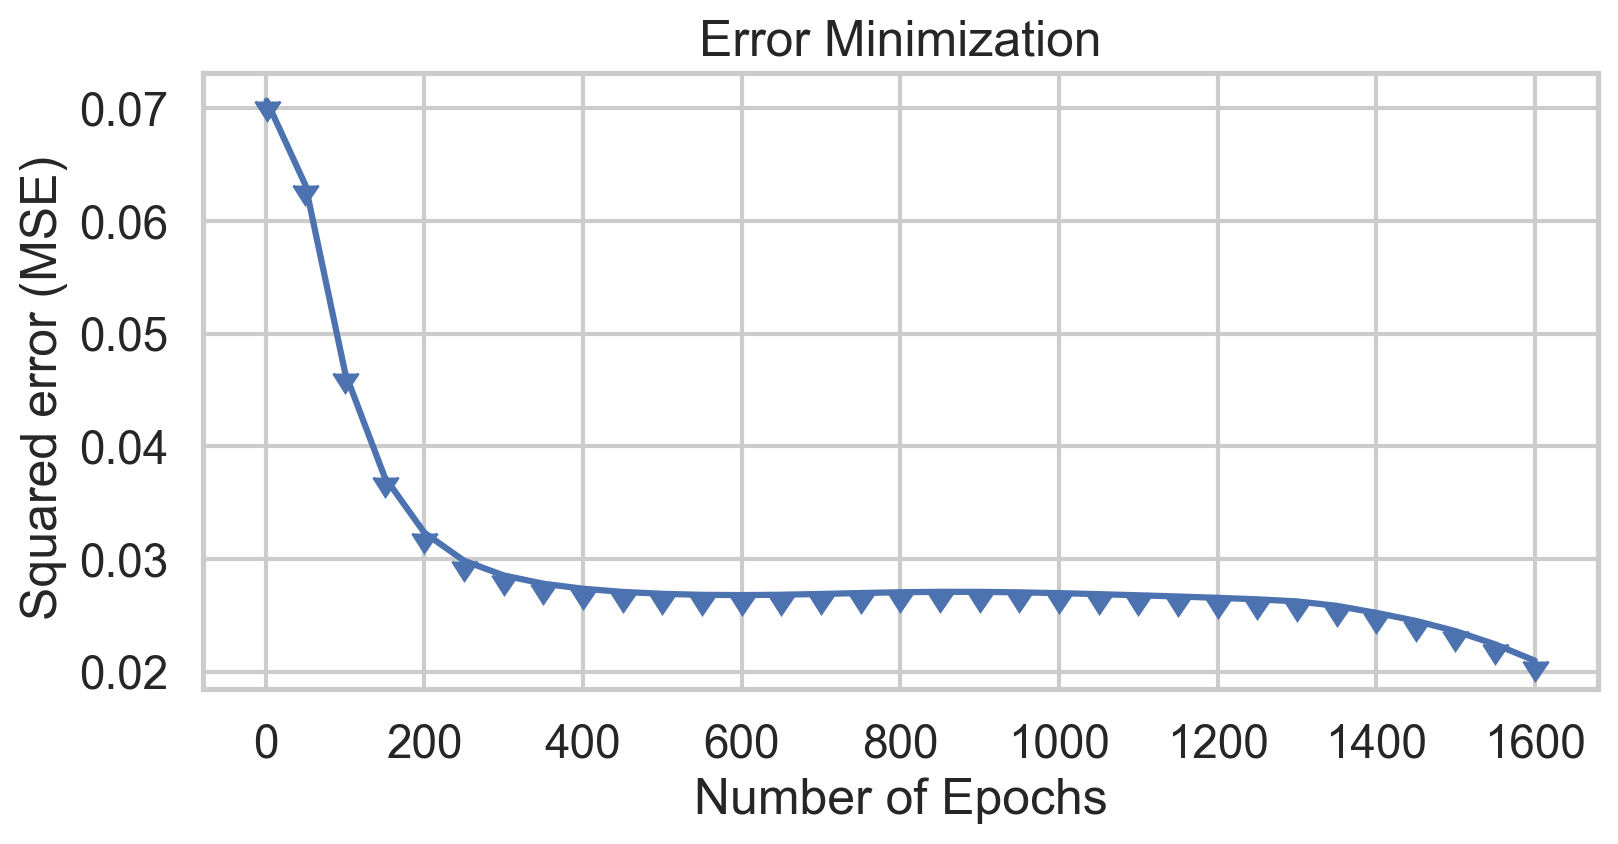

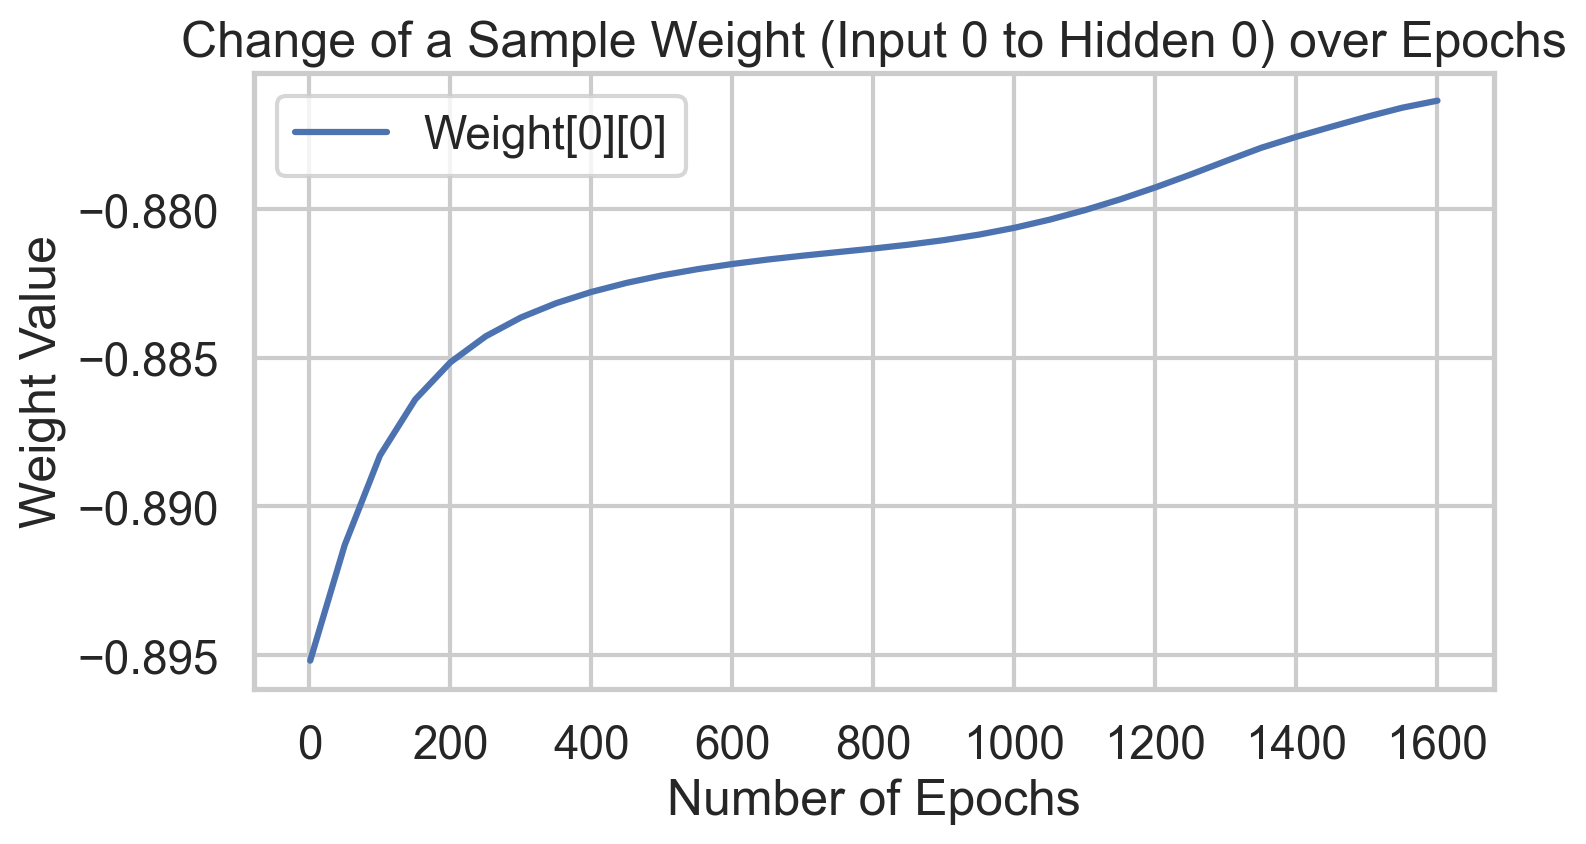

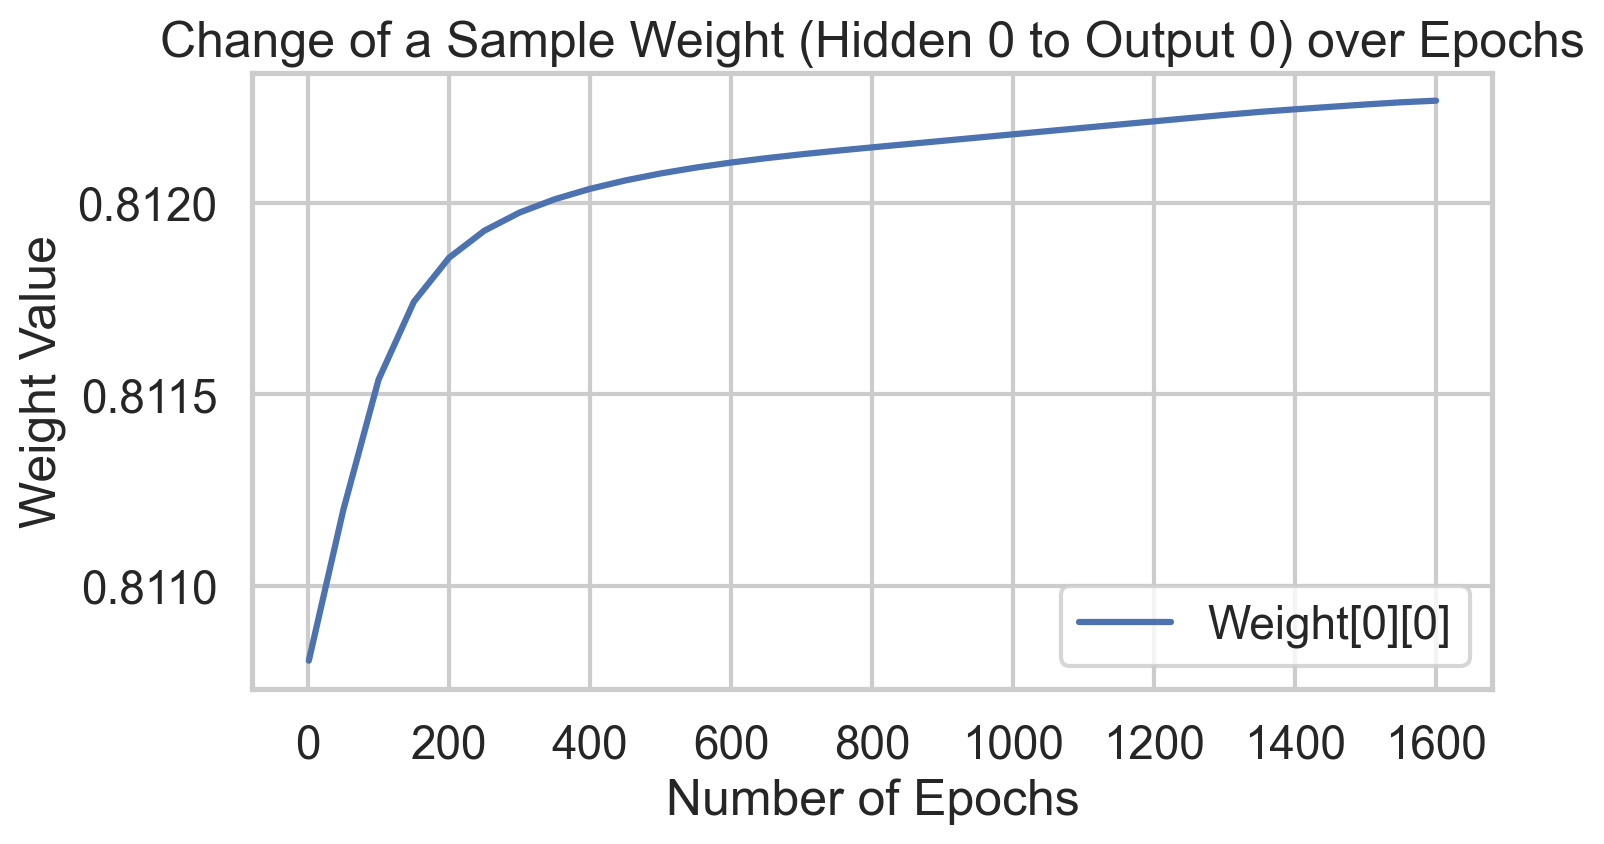

,params,"{'ActivationFunction': 'sigmoid', 'BiasHiddenValue': -1, 'BiasOutputValue': -1, 'Epocas': 1600, ...}"


In [520]:
dictionary = {'InputLayer':4, 'HiddenLayer':5, 'OutputLayer':3,
              'Epocas':1600, 'LearningRate':0.005,'BiasHiddenValue':-1,
              'BiasOutputValue':-1, 'ActivationFunction':'sigmoid'}

Perceptron = MultiLayerPerceptron(dictionary)
Perceptron.fit(train_X,train_y)

In [521]:
prev, dataframe = Perceptron.predict(test_X, test_y)
hits = n_set = n_vers = n_virg = 0
score_set = score_vers = score_virg = 0
for j in range(len(test_y)):
    if(test_y[j] == 0): n_set += 1
    elif(test_y[j] == 1): n_vers += 1
    elif(test_y[j] == 2): n_virg += 1

for i in range(len(test_y)):
    if test_y[i] == prev[i]:
        hits += 1
    if test_y[i] == prev[i] and test_y[i] == 0:
        score_set += 1
    elif test_y[i] == prev[i] and test_y[i] == 1:
        score_vers += 1
    elif test_y[i] == prev[i] and test_y[i] == 2:
        score_virg += 1

hits = (hits / len(test_y)) * 100
faults = 100 - hits

print("Porcents :","%.2f"%(hits),"% hits","and","%.2f"%(faults),"% faults")
print("Total samples of test",len(test_y))
print("*Iris-Setosa:",n_set,"samples", score_set, "hits")
print("*Iris-Versicolour:",n_vers,"samples", score_vers, "hits")
print("*Iris-Virginica:",n_virg,"samples", score_virg, "hits")

Porcents : 96.67 % hits and 3.33 % faults
Total samples of test 30
*Iris-Setosa: 10 samples 10 hits
*Iris-Versicolour: 10 samples 10 hits
*Iris-Virginica: 10 samples 9 hits


In [522]:
dataframe

,_id,class,output,hoped_output
0,0,Iris-versicolour,1,1
1,1,Iris-setosa,0,0
2,2,Iris-versicolour,1,1
3,3,Iris-virginica,2,2
4,4,Iris-virginica,2,2
5,5,Iris-versicolour,1,1
6,6,Iris-virginica,2,2
7,7,Iris-setosa,0,0
8,8,Iris-virginica,2,2
9,9,Iris-setosa,0,0


- Acurracy Iris-Setosa: 100.00 %
- Acurracy Iris-Versicolour: 100.00 %
- Acurracy Iris-Virginica: 90.00 %


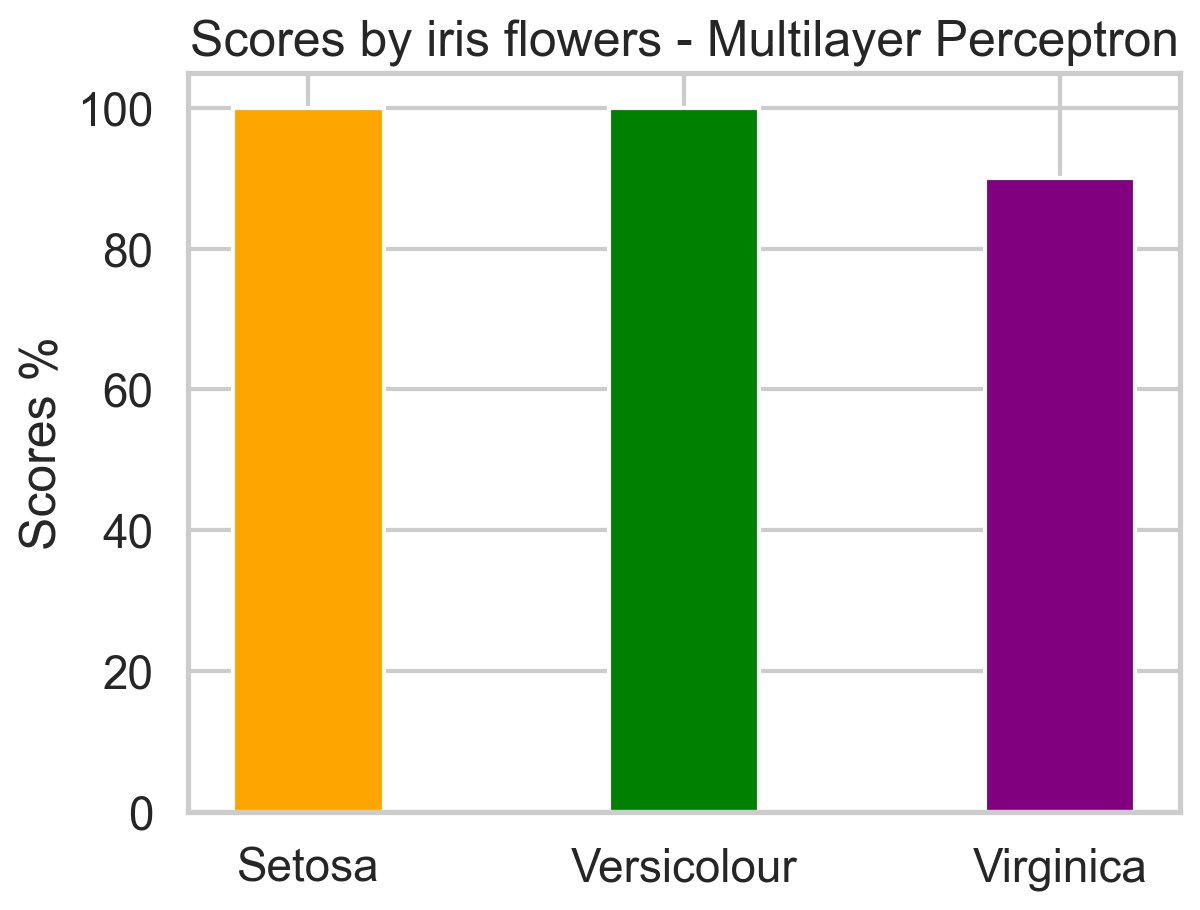

In [523]:
acc_set = (score_set/n_set)*100
acc_vers = (score_vers/n_vers)*100
acc_virg = (score_virg/n_virg)*100
print("- Acurracy Iris-Setosa:","%.2f"%acc_set, "%")
print("- Acurracy Iris-Versicolour:","%.2f"%acc_vers, "%")
print("- Acurracy Iris-Virginica:","%.2f"%acc_virg, "%")
names = ["Setosa","Versicolour","Virginica"]
x1 = [2.0,4.0,6.0]
fig, ax = plt.subplots()
r1 = plt.bar(x1[0], acc_set,color='orange',label='Iris-Setosa')
r2 = plt.bar(x1[1], acc_vers,color='green',label='Iris-Versicolour')
r3 = plt.bar(x1[2], acc_virg,color='purple',label='Iris-Virginica')
plt.ylabel('Scores %')
plt.xticks(x1, names);plt.title('Scores by iris flowers - Multilayer Perceptron')
plt.show()